<h1> Using MOMENT for Forecasting </h1>
<hr>

## Contents
### 1. A Quick Introduction to Forecasting
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Supervised Learning using Forecasting Head

## 1. A Quick Introduction to Forecasting

Time series forecasting is another popular modeling task that involves predicting future values of a time series based on its historical patterns. For instance, in the context of stock market data, forecasting aims to estimate the future stock prices by analyzing past price movements and other relevant factors. In this tutorial, we will explore how to use MOMENT to tackle the time series forecasting in linearly probed setting. Mathematically, the time series forecasting problem can be defined as follows:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), the forecasting problem is to predict the next $H$ time-steps $[x_{L+1}, \dots, x_{L+H}]$. Depending on the length of the horizon, forecasting can be categorized as short or long-horizon

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model.

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding model`, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` notebook for more details!

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
!pip install numpy pandas scikit-learn matplotlib tqdm
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

In [2]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 192,
        'head_dropout': 0.1,
        'weight_decay': 0
    },
)

In [3]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs:

1. An input time series of length $T = 512$ timesteps and $C$ channels, and
2. Two optional masks, both of length $T = 512$.
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our paper). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a forecasting task, it returns a `forecast` of the input.

In [4]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[-0.0394, -0.0339, -0.0472,  ..., -0.1528, -0.0339, -0.0920]],

        [[ 0.0984, -0.0186, -0.0139,  ..., -0.0014,  0.0346,  0.0302]],

        [[ 0.0434, -0.0713, -0.0054,  ..., -0.0277, -0.0182, -0.1977]],

        ...,

        [[ 0.0884, -0.0512,  0.0375,  ...,  0.0633,  0.1023, -0.0979]],

        [[ 0.0691, -0.1914, -0.0706,  ..., -0.0568,  0.0377, -0.0867]],

        [[ 0.0374,  0.0764,  0.0647,  ...,  0.0325,  0.0728, -0.1231]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

## 4. Supervised Learning using Forecasting Head

In this approach, we replace MOMENT's reconstruction head with a forecasting head. This forecasting head is randomly initialized and can be trained using MSE-loss and labeled data. To speed up our experiments, we drop all exogenous variables from multi-variate datasets and only consider the target time series for forecasting.

For fine-tuning a linear head on MOMENT for forecasting, you can use the example code below.

In these experiments, we will use Hourly Electricity Transformer Temperature (ETTh1) dataset introduced by [Zhou et al., 2020](https://arxiv.org/abs/2012.07436). Check out [ETDataset](https://github.com/zhouhaoyi/ETDataset) for more information! We will use the ETTh1 dataset since missing values are common in this domain!

We have implemented a simple forecasting dataset class in `moment.data.informer_dataset`. Note that MOMENT was not exposed to the testing part of this dataset during pre-training. The evaluation metrics for the forecasting task are implemented in `moment.utils.forecasting_metrics`.

We train the model for 1 epoch with the prediction horizon set to 192 timesteps. We evaluate the model on the metrics Mean Absolute Error (MAE) and Mean Squared Error (MSE).

### 4.1 Model Finetuning

In [5]:
import random
import numpy as np
import pandas as pd
import torch
import torch.cuda.amp
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 1

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(timeseries, input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(timeseries, input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')
    print(f"MAE: {metrics.mae:.3f}")
    print(f"MSE: {metrics.mse:.3f}")

100%|██████████| 993/993 [11:05<00:00,  1.49it/s]


loss: 0.377


100%|██████████| 337/337 [01:06<00:00,  5.05it/s]

MAE: 0.457
MSE: 0.461


### 4.2 Visualization

Next, let's visualize the forecasts for a sample from the ETTh1 dataset and compare it with the ground truth forecast for the given time series.

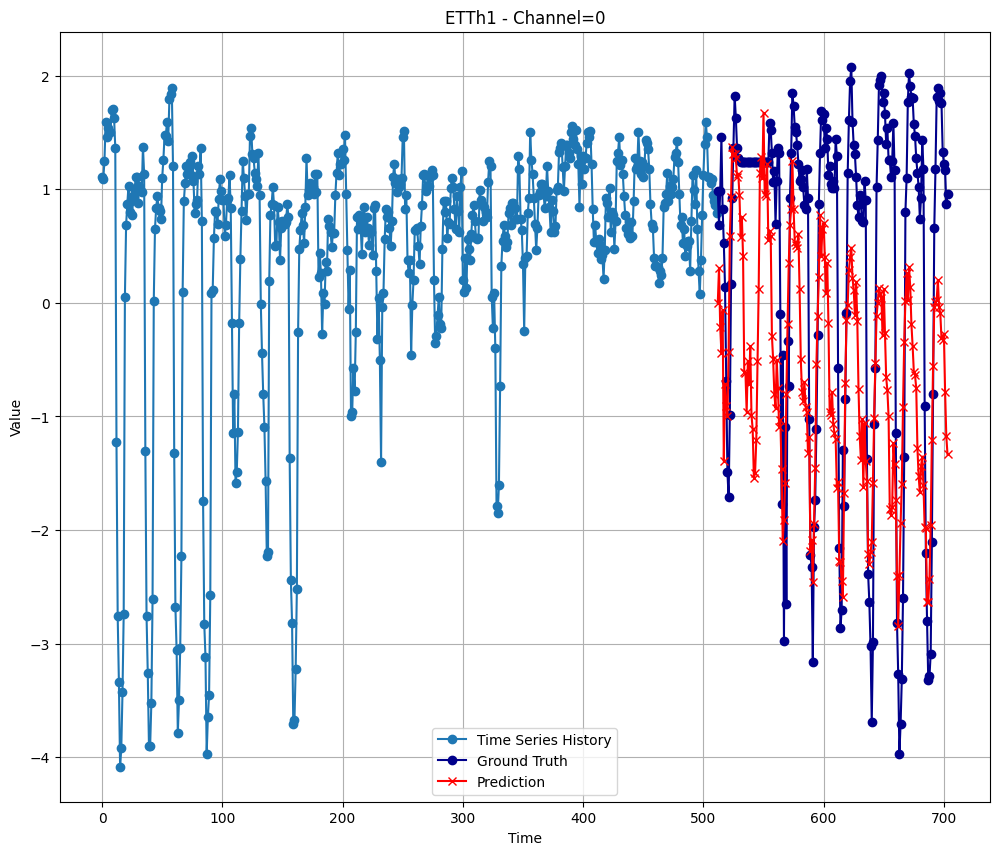

Difference between Ground Truth and Prediction: [ 0.9829375   0.37713724  1.1971219   1.8968294   0.88932025  1.9191699
  0.8569062   0.219679   -0.4930172  -1.2768123  -1.5706918  -0.7652173
 -0.44339782  0.05234993  0.515419    0.35406506  0.2528745   0.1349833
  0.3141464   0.66011095  0.4850617   0.82518864  1.8472085   1.85759
  2.200722    1.7515905   1.9526615   1.6215501   2.2269487   2.3504324
  2.7820797   2.7361827   2.4465969   1.7499514   1.1120427   0.09275472
 -0.05039918  0.1391977  -0.4339639   0.2812587   0.30120194  0.01298189
  0.6844594   0.9470973   0.9378893   1.609895    1.5619287   1.9562926
  1.6241851   1.5805581   2.1155133   2.4147253   0.9297438  -0.3050481
  1.6378837  -1.066936    0.4950422  -1.8502597  -0.155388   -1.0814812
  0.238222    0.49389625  0.5974817   0.90420187  1.0116878   0.99274796
  0.9008081   0.61648417  0.9563091   1.5811568   1.9525203   1.8835427
  1.5560712   1.7389545   2.1377983   2.251391    0.16188645 -0.03552961
 -0.23307419 -

In [7]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point
history = histories[0][0]  # Selecting the first time series
true = trues[0][0]
pred = preds[0][0]

# Plotting the first data point
plt.figure(figsize=(12, 10))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='Time Series History', marker='o')

# Plotting ground truth and prediction
# Assuming true and pred are arrays with shape (7, 192) representing forecasts
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth', marker='o', color='darkblue')
plt.plot(range(offset, offset + len(pred)), pred, label='Prediction', marker='x', color='red')

plt.title('ETTh1 - Channel=0')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Showing the difference between ground truth and prediction
difference = true - pred
print("Difference between Ground Truth and Prediction:", difference)


### 4.3 Results Interpretation: MOMENT Performs Well for Forecasting in Limited Supervision Settings

Here, we can see that MOMENT is capable of forecasting time series well, even in limited supervision settings, even without large-scale fine-tuning or extensive hyperparameter tuning.